In [1]:
import numpy as np
print('numpy: %s' % np.__version__) # print version

# Note, need to 'pip install gym', and 'pip install gym[toy_text]' 
# or use 'pip install gym\[toy_text\]' if zsh does not recongize the other command
import gym # for simulated environments
print('gym: %s' % gym.__version__) # print version

import matplotlib
import matplotlib.pyplot as plt # for displaying environment states
print('matplotlib: %s' % matplotlib.__version__) # print version
from IPython import display # for displaying environment states

numpy: 1.23.2
gym: 0.26.2
matplotlib: 3.4.3


In [2]:
# Setup the environment
env = gym.make(id='Taxi-v3', # choose one of the existing environments
               max_episode_steps=None, # default=None, Maximum length of an episode (TimeLimit wrapper).
               autoreset=False, # default=None, Whether to automatically reset the environment after each episode (AutoResetWrapper).
               disable_env_checker=None, # default=None, If to run the env checker
               render_mode = 'rgb_array' # The set of supported modes varies per environment. (And some third-party environments may not support rendering at all.)
              )

In [3]:
# Show environment description (map) as an array
print("Environment Array: ")
print(env.desc)

# Observation and action space 
state_obs_space = env.observation_space # Returns sate(observation) space of the environment.
action_space = env.action_space # Returns action space of the environment.
print("State(Observation) space:", state_obs_space)
print("Action space:", action_space)

Environment Array: 
[[b'+' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'+']
 [b'|' b'R' b':' b' ' b'|' b' ' b':' b' ' b':' b'G' b'|']
 [b'|' b' ' b':' b' ' b'|' b' ' b':' b' ' b':' b' ' b'|']
 [b'|' b' ' b':' b' ' b':' b' ' b':' b' ' b':' b' ' b'|']
 [b'|' b' ' b'|' b' ' b':' b' ' b'|' b' ' b':' b' ' b'|']
 [b'|' b'Y' b'|' b' ' b':' b' ' b'|' b'B' b':' b' ' b'|']
 [b'+' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'+']]
State(Observation) space: Discrete(500)
Action space: Discrete(6)


In [7]:
25*25

625

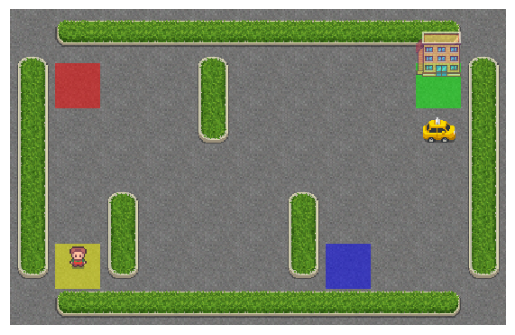

In [9]:
# reset environment to initial state
state , info = env.reset()

for _ in range(30):
    
    plt.imshow(env.render())
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    random_action = env.action_space.sample()
    
    state , reward , done , _ , info = env.step(random_action)
    
    if done:
        plt.imshow(env.render())
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)

        random_action = env.action_space.sample()

        state , reward , done , _ , info = env.step(random_action)
        state , info = env.reset()
env.close()

In [10]:

# SARSA parameters
alpha = 0.1   # learning rate
gamma = 0.95  # discount factor

# Training parameters
n_episodes = 100000  # number of episodes to use for training
n_max_steps = 100   # maximum number of steps per episode

# Exploration / Exploitation parameters
start_epsilon = 1.0  # start training by selecting purely random actions
min_epsilon = 0.0   # the lowest epsilon allowed to decay to
decay_rate = 0.00001   # epsilon will gradually decay so we do less exploring and more exploiting as Q-function improves

In [11]:
# initial Q-table
# our Q-table is a matrix of state(observation) space * action space i.e 500 * 6
Qtable = np.zeros((state_obs_space.n , action_space.n))

# SARSA is an on-policy algorithm, so we will use the same epsilon-greedy strategy to act and update the Q-table. 

In [22]:
def epsilon_greedy(Qtable , state , epsilon):
    # Generate a random number and compare to elipson , if lower -> explore , otherwise -> exploit
    randum = np.random.uniform(0,1)
    if randum < epsilon:
        action = env.action_space.sample() # explore
    else:
        action = np.argmax(Qtable[state,:]) # exploit
    return action

# This function is to update the Qtable.
# It is also based on epsilon-greedy approach because the next_action is decided by epsilon-greedy policy
def update_Q(Qtable, state, action, reward, next_state, next_action):
    # 𝑄(𝑆𝑡,𝐴𝑡)=𝑄(𝑆𝑡,𝐴𝑡)+𝛼[𝑅𝑡+1+𝛾𝑄(𝑆𝑡+1,𝐴𝑡+1)−𝑄(𝑆𝑡,𝐴𝑡)]
    Qtable[state][action] = Qtable[state][action] + alpha * \
    (reward + gamma *(Qtable[next_state][next_action])-Qtable[state][action])
    return Qtable

# This function (greedy) will return the action from Qtable when we do evaluation

def eval_greedy(Qtable , state):
    action = np.argmax(Qtable[state,:])
    return action

In [23]:
def train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable):
    for episode in range(n_episodes):
        
        # Reset the environment at the start of each episode
        state, info = env.reset()
        t = 0
        done = False
        
        # Calculate epsilon value based on decay rate
        epsilon = max(min_epsilon, (start_epsilon - min_epsilon)*np.exp(-decay_rate*episode))
        
        # Choose an action using previously defined epsilon-greedy policy
        action = epsilon_greedy(Qtable, state, epsilon)
        
        for t in range(n_max_steps):
            
            # Perform the action in the environment, get reward and next state
            next_state, reward, done, _, info = env.step(action)
            
            # Choose next action
            next_action=epsilon_greedy(Qtable, next_state, epsilon)
            
            # Update Q-table
            Qtable = update_Q(Qtable, state, action, reward, next_state, next_action)
            
            # Update current state 
            state = next_state
            action = next_action
            
            # Finish the episode when done=True, i.e., reached the goal or fallen into a hole
            if done:
                break
                
    # Return final Q-table
    return Qtable

In [24]:
# Train
Qtable = train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable)

# Show Q-table
Qtable

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [-16.43305742, -15.87187728, -16.06595592, -14.67543691,
        -10.58946703, -24.46418608],
       [ -7.20599358,  -2.63975921,  -5.57340887,  -3.7787292 ,
          0.77135338, -13.51737875],
       ...,
       [ -1.57801341,   1.79180621,  -3.83149368,  -4.36001146,
        -11.12585487, -11.50450947],
       [-21.86523939, -14.36037968, -16.74555091, -11.18935539,
        -26.61360463, -24.09131847],
       [ 12.01160377,   3.98925952,  12.66035851,  15.21093748,
          3.35776609,   2.05559735]])

In [27]:
def evaluate_agent(n_max_steps , n_eval_episodes,Qtable):
    # initilize empty list to store reward foreach episode
    episode_rewards = []
    
    for episode in range(n_eval_episodes):
        
        # Reset the environment at the start of each episode
        state , info = env.reset()
        t = 0
        done = False
        tot_rewards = 0
        for step in range(n_max_steps):
            
            # use greedy policy to evaluate
            action = eval_greedy(Qtable,state)
            
            next_state , reward ,done , _ ,  info = env.step(action)
            
            tot_rewards +=reward
            
            state = next_state
            
            if done:
                break
        
        episode_rewards.append(tot_rewards)
    
    mean_reward = np.mean(episode_rewards)
    std_reward  = np.std(episode_rewards)
    
    return mean_reward , std_reward , episode_rewards

Mean Reward = 7.92 +/- 2.58
Min = 3.0 and Max 15.0


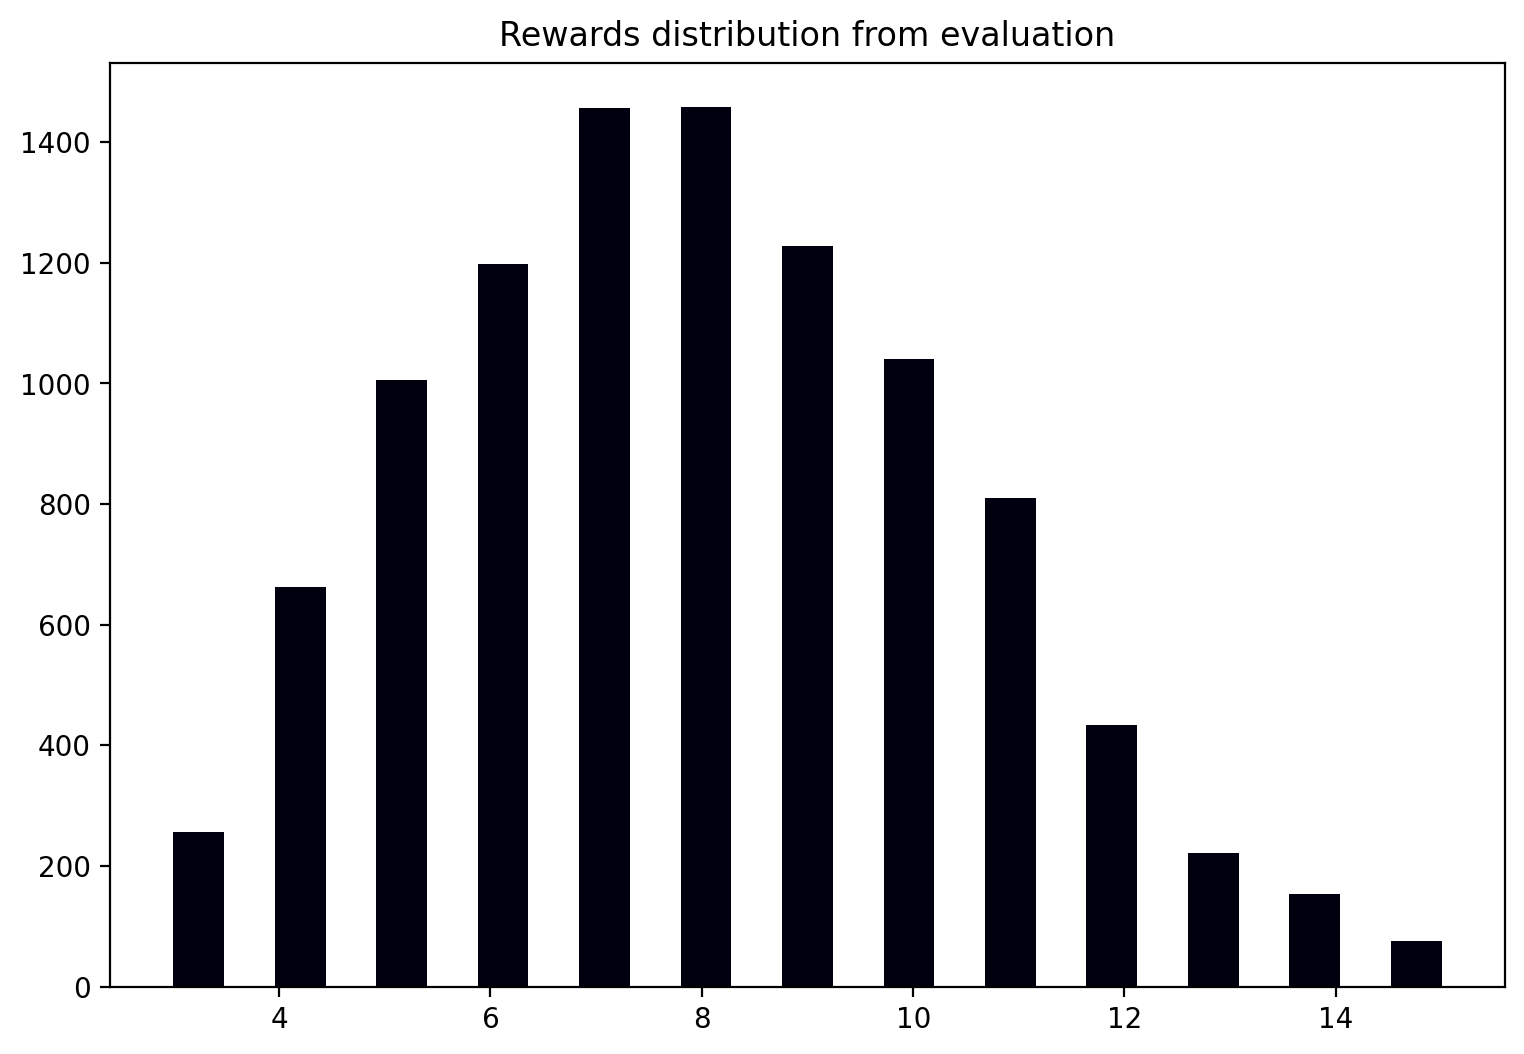

In [28]:

# Evaluate
n_eval_episodes=10000
mean_reward, std_reward, episode_rewards = evaluate_agent(n_max_steps, n_eval_episodes, Qtable)

# Print evaluation results
print(f"Mean Reward = {mean_reward:.2f} +/- {std_reward:.2f}")
print(f"Min = {min(episode_rewards):.1f} and Max {max(episode_rewards):.1f}")

# Show the distribution of rewards obtained from evaluation
plt.figure(figsize=(9,6), dpi=200)
plt.title(label='Rewards distribution from evaluation', loc='center')
plt.hist(episode_rewards, bins=25, color='#00000f')
plt.show()

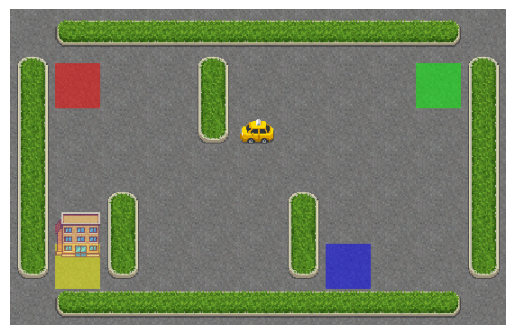

In [29]:

# Reset environment to initial state
state, info = env.reset()

# Cycle through 50 steps redering and displaying environment state each time
for _ in range(50):
    
    # Render and display current state of the environment
    plt.imshow(env.render()) # render current state and pass to pyplot
    plt.axis('off')
    display.display(plt.gcf()) # get current figure and display
    display.clear_output(wait=True) # clear output before showing the next frame
    
    # Use greedy policy to evaluate
    action = eval_greedy(Qtable, state)
    
    # Pass action into step function
    state, reward, done, _, info = env.step(action)
    
    # Reset environment when done=True, i.e. when the agent falls into a Hole (H) or reaches the Goal (G)
    if done:
        # Render and display final state of the environment
        plt.imshow(env.render()) # render current state and pass to pyplot
        plt.axis('off')
        display.display(plt.gcf()) # get current figure and display
        display.clear_output(wait=True) # clear output before showing the next frame
        state, info = env.reset()

env.close()